In [1]:
hpath='/exp/jvillalba/hyperion/hyperion-persephone'
import sys
sys.path.append(hpath)

In [25]:
from copy import deepcopy
import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import hyperion as hyp
import hyperion.np as hnp
import hyperion.torch as ht


In [3]:
class IVDataset(Dataset):
    """Datasets that generates utterances following the i-vector model.
    
    Attributes:
      num_samples: num. of utterances in the dataset.
      num_spks: num. of speakers in the dataset.
      x_dim: feature dimension.
      num_gauss: number of Gaussian components in UBM-GMM
      w_dim: i-vector dimension.
      sb: isotropic between-class cov.
      sw: isotropic within-class cov.
      
    """
    
    def __init__(self, num_samples=10000, num_spks=100, x_dim=16, num_gauss=32, w_dim=16, sb=0.7, sw=0.3, utt_length=200, unit_length=25, seed=1234):
        self.rng = np.random.RandomState(seed=seed)
        self.num_samples = num_samples
        self.num_spks = num_spks
        self.x_dim = x_dim
        self.w_dim = w_dim
        self.num_gauss = num_gauss
        self.utt_length = utt_length
        self.unit_length = unit_length
        self.sb = sb
        self.sw = sw
        self.y = self._make_spks(num_spks, w_dim, sb, self.rng)
        self.gmm_ubm = self._make_ubm(x_dim, num_gauss, self.rng)
        self.T = self._make_ivector(x_dim, num_gauss, w_dim, self.rng)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        spk_idx = idx % self.y.shape[0]
        x = self.sample_utterance(spk_idx)
        x = x.astype('float32')
        return x, spk_idx


    @staticmethod
    def _make_spks(num_spks, w_dim, sb, rng):
        """Creates the speaker identity vectors"""
        return np.sqrt(sb) * rng.randn(num_spks, w_dim)

    @staticmethod
    def _make_ubm(x_dim, num_gauss, rng):
        """Creates the UBM GMM"""
        # Define UBM
        # Means of the GMM-UBM
        ubm_means = rng.randn(num_gauss, x_dim)
        ubm_means = np.sqrt(x_dim) * ubm_means/np.linalg.norm(ubm_means, axis=-1, keepdims=True)

        # Covariances of the GMM-UBM
        ubm_cov = 0.1 * np.ones((num_gauss, x_dim))
        ubm_prec = 1./ubm_cov

        # Weights of the GMM-UBM
        ubm_weights = np.ones((num_gauss))/num_gauss

        return hnp.pdfs.GMMDiagCov(pi=ubm_weights, mu=ubm_means, Lambda=ubm_prec)

    @staticmethod
    def _make_ivector(x_dim, num_gauss, w_dim, rng):
        # Define Total Variability sub-space
        T = rng.randn(w_dim, x_dim * num_gauss)
        T = 0.2 * T/np.max(T)
        return T

    def sample_utterance(self, spk_idx):
        # generate i-vector
        y = self.y[spk_idx] # spk factor
        w = y + np.sqrt(self.sw) * self.rng.randn(self.w_dim)

        # For each utterance
        # Compute the GMM mean of the utterance
        means_i = self.gmm_ubm.mu + np.dot(w, self.T).reshape(self.x_dim, self.num_gauss).T

        # Create a GMM for the utterance.
        gmm = self.gmm_ubm.copy()
        gmm.mu = means_i
      
        # Sample the Gaussian components
        num_units = self.utt_length // self.unit_length
        r = self.rng.multinomial(1, gmm.pi, size=(num_units,))
        # Assume that we stay in the same component several time steps.
        r = np.repeat(r, self.unit_length, axis=0)
        # Draw samples from the GMM
        x = gmm.sample(r=r)
        return x




In [4]:
# Create the Training dataset
train_data = IVDataset()
# The Validation dataset is a copy of the training data but with less samples
val_data = deepcopy(train_data)
val_data.num_samples = 100

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [5]:
class StemBlock(nn.Module):
    """Build block input layer of x-vector model

    Args:
      in_channels:   input channels.
      out_channels:  output channels.
      kernel_size:   kernels size for the convolution.
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
    ):

        super().__init__()

        self.activation = nn.ReLU()
        padding = int((kernel_size - 1) // 2)
        self.bn = nn.BatchNorm1d(out_channels)
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            bias=False,
            kernel_size=kernel_size,
            padding=padding,
        )

    def forward(self, x, x_mask=None):
        """Forward function.

        Args:
          x: input tensor with shape = (batch, in_channels, in_time).
          x_mask: unused.

        Returns:
          Tensor with shape = (batch, out_channels, out_time).
        """

        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

In [6]:
class TDNNBlock(nn.Module):
    """TDNN Layer block.

    Attributes:
      in_channels:       input channels.
      out_channels:          output channels.
      kernel_size:       kernel size.
      dilation:          dilation factor of the conv. kernels.
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3,
        dilation=1,
    ):

        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm1d(out_channels)

        padding = int(dilation * (kernel_size - 1) // 2)
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            bias=False,
            kernel_size=kernel_size,
            dilation=dilation,
            padding=padding,
        )


    def forward(self, x):
        """Forward function.

        Args:
          x: input tensor with shape = (batch, in_channels, time).
          x_mask: unused.

        Returns:
          Tensor with shape = (batch, out_channels, time).
        """
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


In [7]:
class StatsPooling(nn.Module):
    """mean + stddev pooling layer."""

    def forward(self, x):
        x_mean = torch.mean(x, dim=-1)
        x2_mean = torch.mean(x**2, dim=-1)
        x_std = torch.sqrt((x2_mean-x_mean**2).clamp(min=1e-5))
        return torch.cat((x_mean, x_std), dim=-1)
        

In [8]:
class TDNNXVec(ht.TorchModel):

    def __init__(self, feat_dim, num_layers, layer_dim, embed_dim, num_classes):
        super().__init__()
        self.in_block = StemBlock(feat_dim, layer_dim, kernel_size=5)
        tdnn_layers = []
        for i in range(num_layers):
            layer_i = TDNNBlock(layer_dim, layer_dim, kernel_size=3, dilation=i+2)
            tdnn_layers.append(layer_i)

        self.tdnn_layers = nn.ModuleList(tdnn_layers)
        self.pooling = StatsPooling()
        self.projection = nn.Linear(2*layer_dim, embed_dim)
        self.output = nn.Linear(embed_dim, num_classes)

    def update_loss_margin(self, epoch):
        pass

    def forward(self, x, y=None, infer=False):
        x = x.transpose(1,2)
        x = self.in_block(x)
        for i, layer in enumerate(self.tdnn_layers):
            x = layer(x)

        x = self.pooling(x)
        z = self.projection(x)
        if infer:
            return z

        return self.output(z)


In [9]:
model = TDNNXVec(16, 2, 32, 16, 100)


In [12]:
from hyperion.torch.trainers import XVectorTrainer
from hyperion.torch.metrics import CategoricalAccuracy

optim = {"opt_type": "sgd", "lr": 0.01, "momentum": 0.9}
lrsched = {"lrsch_type": "exp_lr", "decay_rate": 0.5, "decay_steps": 4000, "hold_steps": 2000, "warmup_steps": 1000, "update_lr_on_opt_step": True}
metrics = {"acc": CategoricalAccuracy()}
trainer = XVectorTrainer(model, optim=optim, lrsched=lrsched, exp_path='./tdnn_xvec', device=torch.device('cpu'), train_mode="full", metrics=metrics )

INFO:root:optimizer args={'opt_type': 'sgd', 'lr': 0.01, 'momentum': 0.9, 'oss': False}
INFO:root:lr scheduler args={'lrsch_type': 'exp_lr', 'decay_rate': 0.5, 'decay_steps': 4000, 'hold_steps': 2000, 'warmup_steps': 1000, 'update_lr_on_opt_step': True}


In [13]:
logger = logging.getLogger()
logger.setLevel(0)
trainer.fit(train_loader, val_loader)

INFO:root:epoch: 1/100 starts
INFO:root:epoch: 1/100  et: 0s eta: 14s batches: 10/313(3%) samples: 320 loss: 4.601476 acc: 0.018750 lr: 0.000090
INFO:root:epoch: 1/100  et: 0s eta: 13s batches: 20/313(6%) samples: 640 loss: 4.598933 acc: 0.018750 lr: 0.000190
INFO:root:epoch: 1/100  et: 1s eta: 13s batches: 30/313(9%) samples: 960 loss: 4.598896 acc: 0.018750 lr: 0.000290
INFO:root:epoch: 1/100  et: 1s eta: 12s batches: 40/313(12%) samples: 1280 loss: 4.598870 acc: 0.016406 lr: 0.000390
INFO:root:epoch: 1/100  et: 2s eta: 12s batches: 50/313(15%) samples: 1600 loss: 4.598446 acc: 0.016250 lr: 0.000490
INFO:root:epoch: 1/100  et: 2s eta: 11s batches: 60/313(19%) samples: 1920 loss: 4.596868 acc: 0.015625 lr: 0.000590
INFO:root:epoch: 1/100  et: 3s eta: 11s batches: 70/313(22%) samples: 2240 loss: 4.596662 acc: 0.016071 lr: 0.000690
INFO:root:epoch: 1/100  et: 3s eta: 10s batches: 80/313(25%) samples: 2560 loss: 4.596169 acc: 0.016797 lr: 0.000790
INFO:root:epoch: 1/100  et: 4s eta: 10s 

In [36]:
import pandas as pd
train_result = pd.read_csv('./tdnn_xvec/train.log')
train_result = train_result[train_result.index>20]
print(train_result)

     epoch  train_loss  train_acc        lr  val_loss  val_acc
21       1    4.597061     0.0185  0.003120  4.604409     0.03
22       2    4.576668     0.0248  0.006250  4.550752     0.03
23       3    4.429581     0.0333  0.009380  4.132248     0.03
24       4    3.932376     0.0777  0.010000  3.541716     0.11
25       5    3.252122     0.1659  0.010000  3.084885     0.17
..     ...         ...        ...       ...       ...      ...
116     96    0.799725     0.7515  0.000077  0.671766     0.78
117     97    0.781655     0.7553  0.000073  0.714923     0.77
118     98    0.771329     0.7589  0.000070  0.513621     0.84
119     99    0.778845     0.7587  0.000066  0.385253     0.89
120    100    0.777107     0.7624  0.000062  0.483041     0.85

[100 rows x 6 columns]


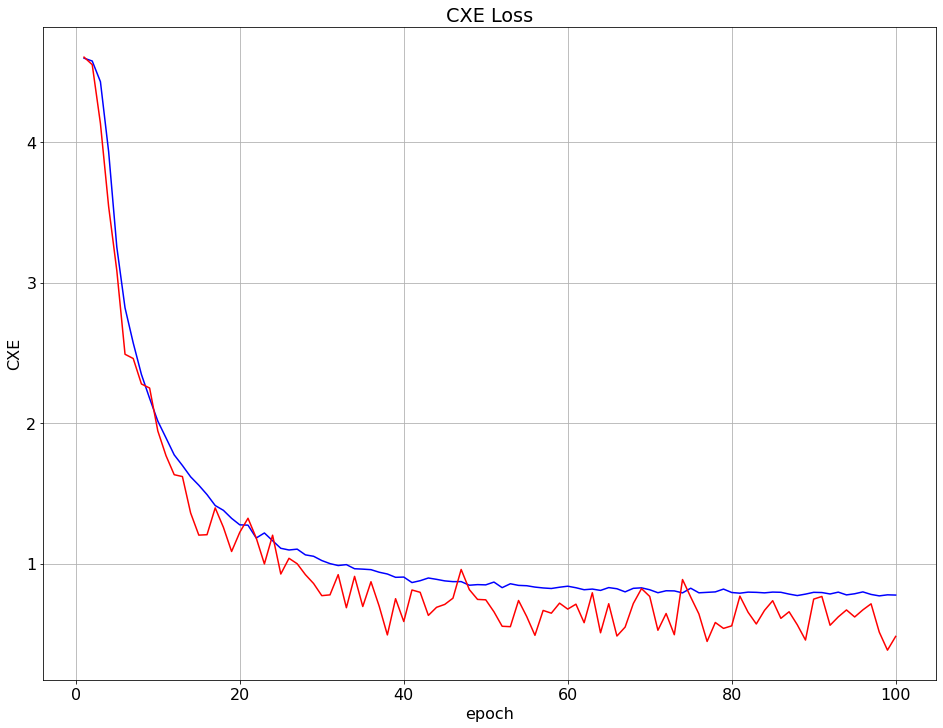

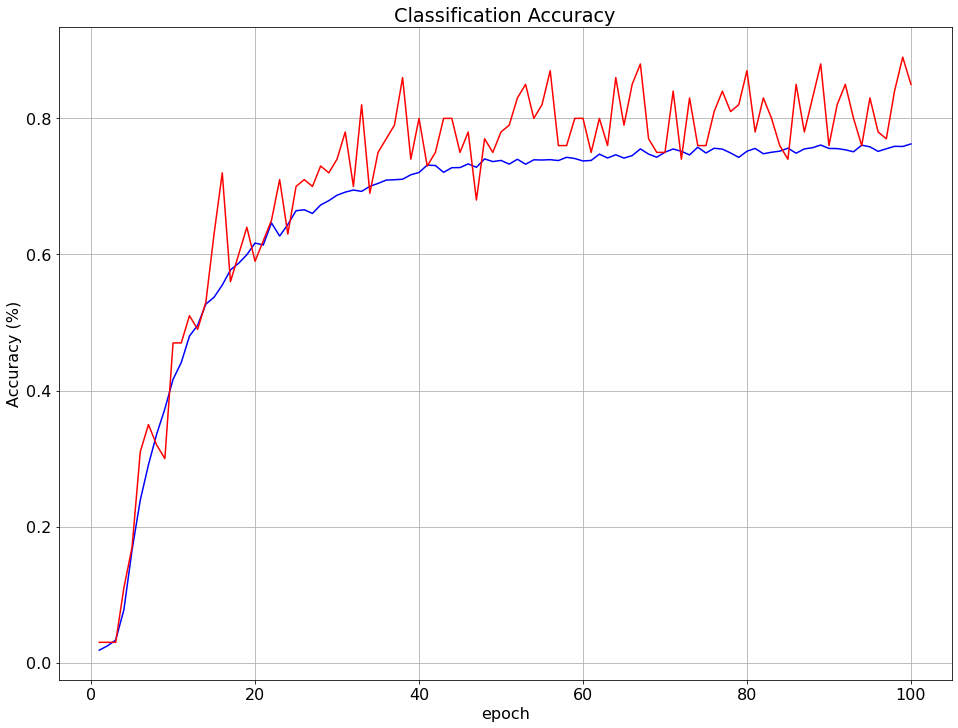

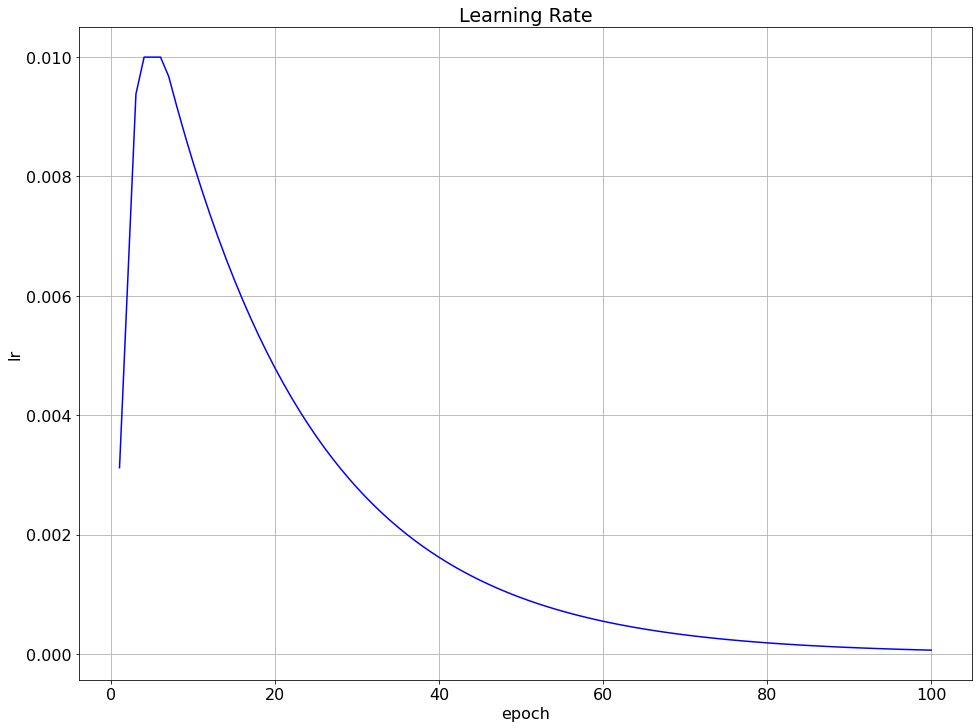

In [37]:
logger.setLevel(3)
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(16,12))
plt.plot(train_result['epoch'], train_result['train_loss'], color='b', label='train')
plt.plot(train_result['epoch'], train_result['val_loss'], color='r', label='va')
plt.title('CXE Loss')
plt.ylabel('CXE')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

plt.figure(figsize=(16,12))
plt.plot(train_result['epoch'], train_result['train_acc'], color='b', label='train')
plt.plot(train_result['epoch'], train_result['val_acc'], color='r', label='va')
plt.title('Classification Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

plt.figure(figsize=(16,12))
plt.plot(train_result['epoch'], train_result['lr'], color='b')
plt.title('Learning Rate')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.grid(True)
plt.show()


In [17]:
model = TDNNXVec(16, 2, 32, 16, 100)
state_dict=torch.load("./tdnn_xvec/model_ep0099.pth")
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [18]:
# Create the Trials dataset with different speakers than the train data.
#trial_data = IVDataset(num_spks=20, seed=4321)
trial_loader = DataLoader(train_data, batch_size=100, shuffle=True)
# sample enrollment data and compute x-vectors
x_e, y_e = next(iter(trial_loader))
z_e = model(x_e, infer=True).detach().cpu().numpy()
# sample test data and compute x-vectors
x_t, y_t = next(iter(trial_loader))
z_t = model(x_t, infer=True).detach().cpu().numpy()


In [19]:
from hyperion.utils.math import cosine_scoring
from hyperion.np.metrics import compute_eer
scores = cosine_scoring(z_e, z_t)
key = (y_e[:, None] - y_t[None,:])==0
tar_scores = scores[key==1]
non_scores = scores[key==0]
eer = compute_eer(tar_scores, non_scores)
print(eer)

0.12987226757966816
